## Overview

#### For this final project, I'll work on an image classification model for determining happy and sad images. Similar to the cancer classification, images can be classified with 0 and 1 for happy and sad. I will use the Keras Sequential model with convolutional 2D layers. A model like this could be used for sentiment analysis or determining emotions in real-time. This will be a fairly simplified model with only binary output but could be expanded for other emotions such as angry, scared, surprised, etc.

#### Most of the images I retrieved from Google searches and some were from a Kaggle dataset for emotions. 

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import os
import PIL
import PIL.Image
import matplotlib.image as mpimg

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
import cv2
import imghdr #check file extensions

In [88]:
!pip show tensorflow

Name: tensorflow
Version: 2.16.1
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /Users/johnkaiser/miniconda/envs/tensorflow/lib/python3.9/site-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, ml-dtypes, numpy, opt-einsum, packaging, protobuf, requests, setuptools, six, tensorboard, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: 


### Setting GPU for TensorFlow

In [2]:
#use the following to avoid an Out Of Memory error by setting GPU Memory Consumption
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### Setting data directory and removing incompatible images

#### I saved all the images in a local 'Final Data' folder with 2 folders inside: 'Happy' and 'Sad'

In [67]:
data_dir = './Final Data'

In [63]:
os.listdir(data_dir)

['Happy', '.DS_Store', 'Sad']

In [9]:
image_exts = ['jpg', 'jpeg', 'bmp', 'png']

### This looops through the data sirectory and flags any incompatible images, it took me a while to get 128 valid images of each to have an even 256 images.

In [68]:
for image_class in os.listdir(data_dir):
    if image_class != '.DS_Store':
        for image in os.listdir(os.path.join(data_dir, image_class)):
            image_path = os.path.join(data_dir, image_class, image)
            try:
               img = cv2.imread(image_path)
               tip = imghdr.what(image_path)
               if tip not in image_exts:
                  print('Image not in ext list {} tip: {}'.format(image_path, tip))
                  os.remove(image_path)
            except Exception as e:
               print('Issue with image {}'.format(image_path)) 

In [69]:
happy_path = './Final Data/Happy'
sad_path = './Final Data/Sad'
happy_count = len(os.listdir(happy_path))
sad_count = len(os.listdir(sad_path))
print(f'Happy images: {happy_count}\n')
print(f'Sad images: {sad_count}')

Happy images: 128

Sad images: 128


## Observing the Data

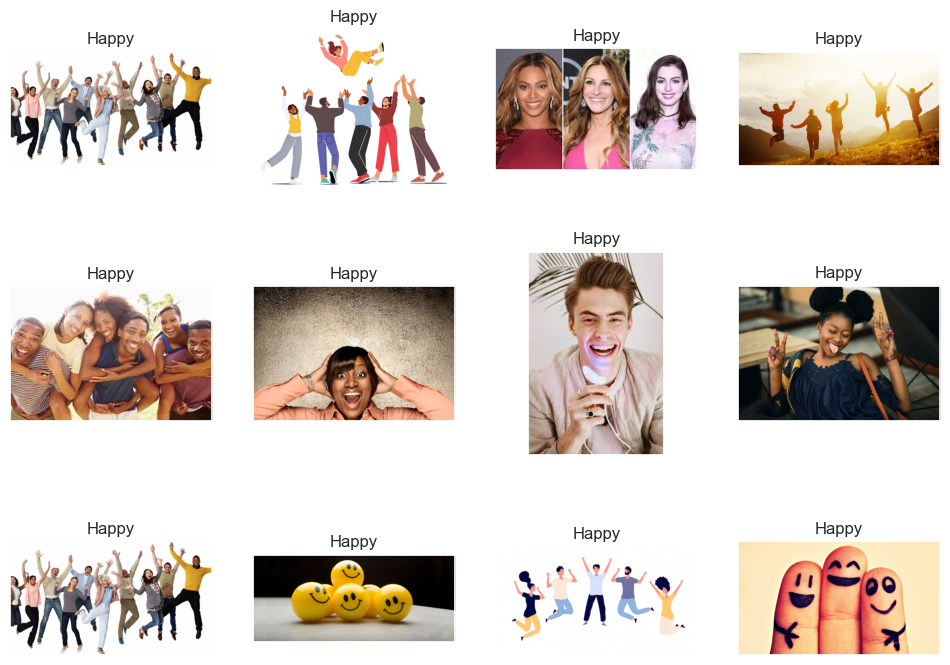

In [70]:
happy_pics = list(os.listdir(happy_path))

def show_batch(image_batch, path, count, label): 
   np.random.seed(42)
   fig = plt.figure(figsize=(12,9), dpi=100)
   for p, i in enumerate(np.random.randint(0, count, 12)):
      ax = fig.add_subplot(3, 12//3, p+1, xticks=[], yticks=[])
      plt.imshow(mpimg.imread(f'{path}/{image_batch[i]}'))
      ax.set_title(label)

show_batch(happy_pics, happy_path, happy_count, 'Happy')

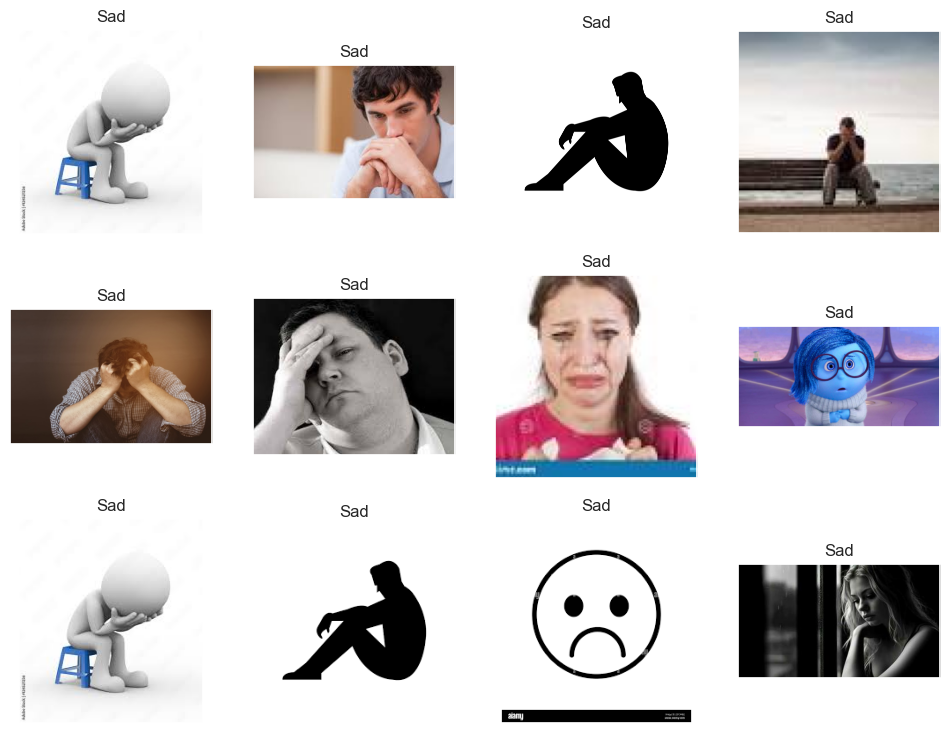

In [71]:
sad_pics = list(os.listdir(sad_path))

show_batch(sad_pics, sad_path, sad_count, 'Sad')

### Load Data

#### Build image dataset using keras, shuffles data by default

In [55]:
tf.data.Dataset

tensorflow.python.data.ops.dataset_ops.DatasetV2

In [72]:
data = tf.keras.utils.image_dataset_from_directory(data_dir)

Found 256 files belonging to 2 classes.


### Default batch size is 32 and image size is 256, 256

In [73]:
data_iterator = data.as_numpy_iterator() # returns an iterator which converts all elements to numpy
batch = data_iterator.next()
batch[0].shape

(32, 256, 256, 3)

### Preprocess Data

#### Scale data to [0, 1] instead of [0, 255]

In [74]:
data = data.map(tf.autograph.experimental.do_not_convert(lambda x,y: (x/255, y)))
scaled_iterator = data.as_numpy_iterator()
batch = scaled_iterator.next()
batch[0].max()

1.0

In [75]:
print(batch[1])

[0 1 0 1 1 0 1 1 0 1 0 0 0 1 1 1 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1 0]


In [89]:
batch[0][0].shape

(256, 256, 3)

### Now the images are classified as 1 for Sad and 0 for Happy and each image is 256 x 256, lets look at 12 rescaled and classified images

0 = Happy
1 = Sad

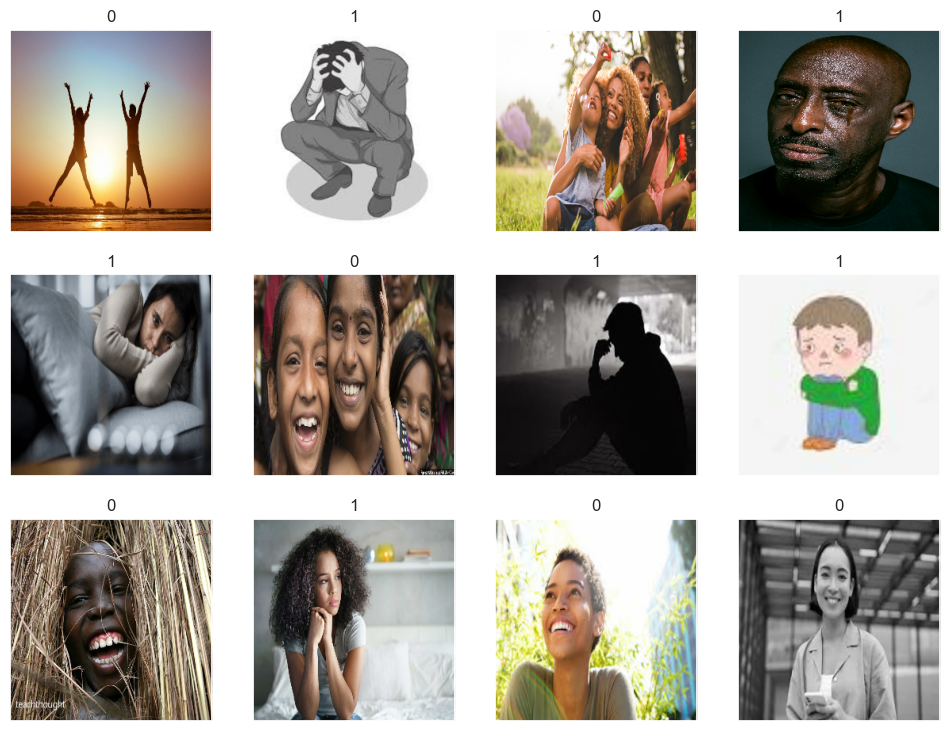

In [76]:

fig = plt.figure(figsize=(12,9), dpi=100)
for p, i in enumerate(batch[0][:12]):
    ax = fig.add_subplot(3, 4, p+1, xticks=[], yticks=[])
    ax.imshow(i)
    ax.set_title(batch[1][p])

In [77]:
len(data)

8

### So now our data is split into 8 batches of 32. Now we can split it up into training, validation and test data

In [84]:
train_size = 6
val_size = 1
test_size = 1

In [85]:
test_size+val_size+train_size

8

In [86]:
# data has already been shuffled 
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [87]:
len(test)

1

## Model Architecture

#### For this first Sequential model, I'll use 3 Convolutional 2D layers each with (3x3) filter size and stride of 1. The input shape is (256, 256, 3). 'relu' activation converts negative values from output to 0 and positive stays the same. MaxPooling2D layer takes max value after relu activation and returns that value to condense the info.

In [90]:
model = Sequential()

model.add(Conv2D(16, (3,3), 1, activation='relu', padding='same', input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())  #condense down to single value layer

model.add(Dense(256, activation='relu'))  #256 output
model.add(Dense(1, activation='sigmoid'))  #final 1 output (0 or 1) with sigmoid

/Users/johnkaiser/miniconda/envs/tensorflow/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [91]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 256, 256, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 126, 126, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 61, 61, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 14400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     3,686,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,696,625 (14.10 MB)

 Trainable params: 3,696,625 (14.10 MB)

 Non-trainable params: 0 (0.00 B)

#### When compiling the model, I used Adam optimizer with binary cross entropy loss but didn't specify the learning rate

In [92]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [93]:
hist = model.fit(train, epochs=20, validation_data=val)

Epoch 1/20


2024-05-23 12:57:00.330843: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 421ms/step - accuracy: 0.5068 - loss: 0.8099 - val_accuracy: 0.4375 - val_loss: 0.7324
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 249ms/step - accuracy: 0.5493 - loss: 0.6778 - val_accuracy: 0.5000 - val_loss: 0.5825
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 268ms/step - accuracy: 0.6476 - loss: 0.6011 - val_accuracy: 0.7812 - val_loss: 0.5312
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 236ms/step - accuracy: 0.7637 - loss: 0.5412 - val_accuracy: 0.9375 - val_loss: 0.4209
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 250ms/step - accuracy: 0.9072 - loss: 0.3884 - val_accuracy: 0.8125 - val_loss: 0.3459
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 261ms/step - accuracy: 0.8536 - loss: 0.3517 - val_accuracy: 0.9062 - val_loss: 0.3213
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 250ms/step - accuracy: 0.9034 - loss: 0.2947 - val_accuracy: 0.9062 - val_loss: 0.2969
Epoch 8/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 224ms/step - accuracy: 0.9458 - loss: 0.1992 - val_accuracy: 0.9688 - val_loss: 0.1439
Epo

## Plot Performance

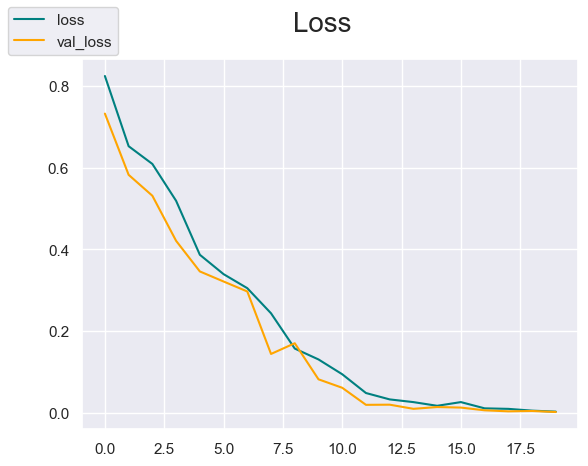

In [94]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
fig.legend(loc='upper left')
plt.show()

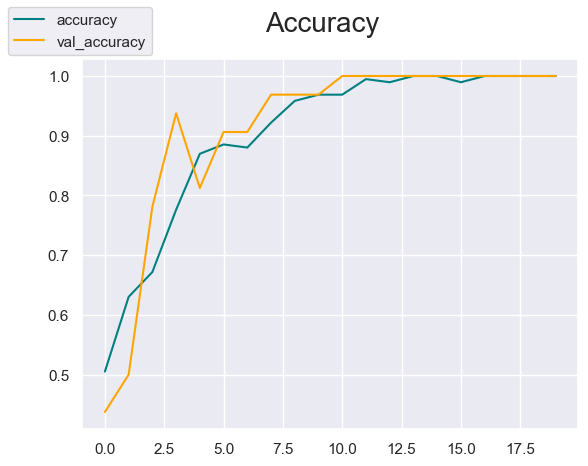

In [95]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
fig.legend(loc='upper left')
plt.show()

### Evaluate Performance

In [96]:
# evaluate model
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [97]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [98]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


2024-05-23 12:58:32.864585: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [99]:
print(f'Precision: {pre.result().numpy()}, Recall: {re.result().numpy()}, Acc: {acc.result().numpy()}')

Precision: 1.0, Recall: 1.0, Acc: 1.0


## Initial Results from Training

#### As we see above, the model performed very well with 100% accuracy. This could be from some possible duplicates in the data and only 256 images isn't much for a true model. 

## Test the Model 

In [139]:
def test_with_image(image):
   img = cv2.imread(image)
   img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
   plt.imshow(img)
   plt.grid(None)
   resize = tf.image.resize(img, (256, 256))
   pred = model.predict(np.expand_dims(resize/255.0, 0))
   if pred > 0.5:
     print('Predicted class is sad')
   else:
    print('Predicted is happy')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Predicted class is sad


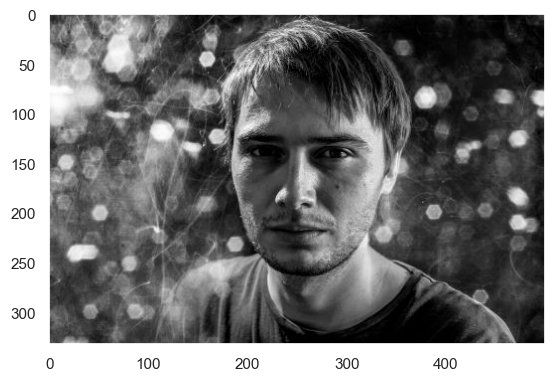

In [140]:
test_with_image('sadtest.jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Predicted is happy


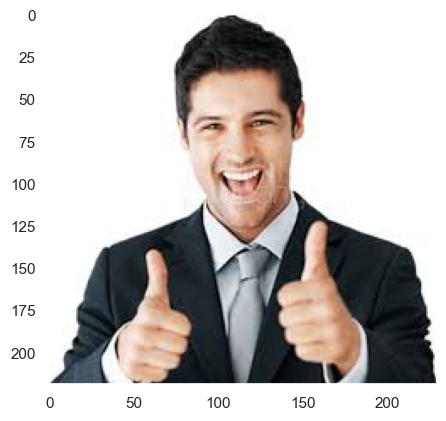

In [141]:
test_with_image('happytest.jpg')

### As expected, both images were classified correctly. Now we can use the test set to make predictions and how they are classified.

In [118]:
test_iter = test.as_numpy_iterator()
test_batch = test_iter.next()
test_batch[0].shape

(32, 256, 256, 3)

In [130]:
test_batch[1]

array([1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 1, 0, 1, 1, 1, 1], dtype=int32)

In [132]:
preds = []
yhat = model.predict(test_batch[0])
for p in yhat:
   if p > 0.5:
      preds.append(1)
   else:
      preds.append(0)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


In [134]:
print(yhat)

[[1.0000000e+00]
 [9.8806775e-01]
 [3.2477980e-04]
 [2.8199118e-05]
 [9.9997139e-01]
 [8.3593550e-05]
 [1.0000000e+00]
 [9.9999106e-01]
 [9.9942076e-01]
 [9.9999976e-01]
 [2.0285275e-04]
 [9.9999702e-01]
 [1.0000000e+00]
 [9.9542999e-01]
 [2.4414444e-04]
 [9.9889547e-01]
 [1.8131465e-06]
 [2.2744118e-05]
 [1.4549832e-06]
 [5.6396978e-04]
 [2.0210374e-02]
 [9.9992609e-01]
 [6.3373672e-04]
 [2.0776554e-04]
 [9.9817073e-01]
 [2.3407527e-05]
 [9.9994290e-01]
 [2.4485865e-04]
 [9.9944073e-01]
 [9.9376994e-01]
 [9.9965119e-01]
 [9.9996769e-01]]


In [133]:
print(preds)

[1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1]


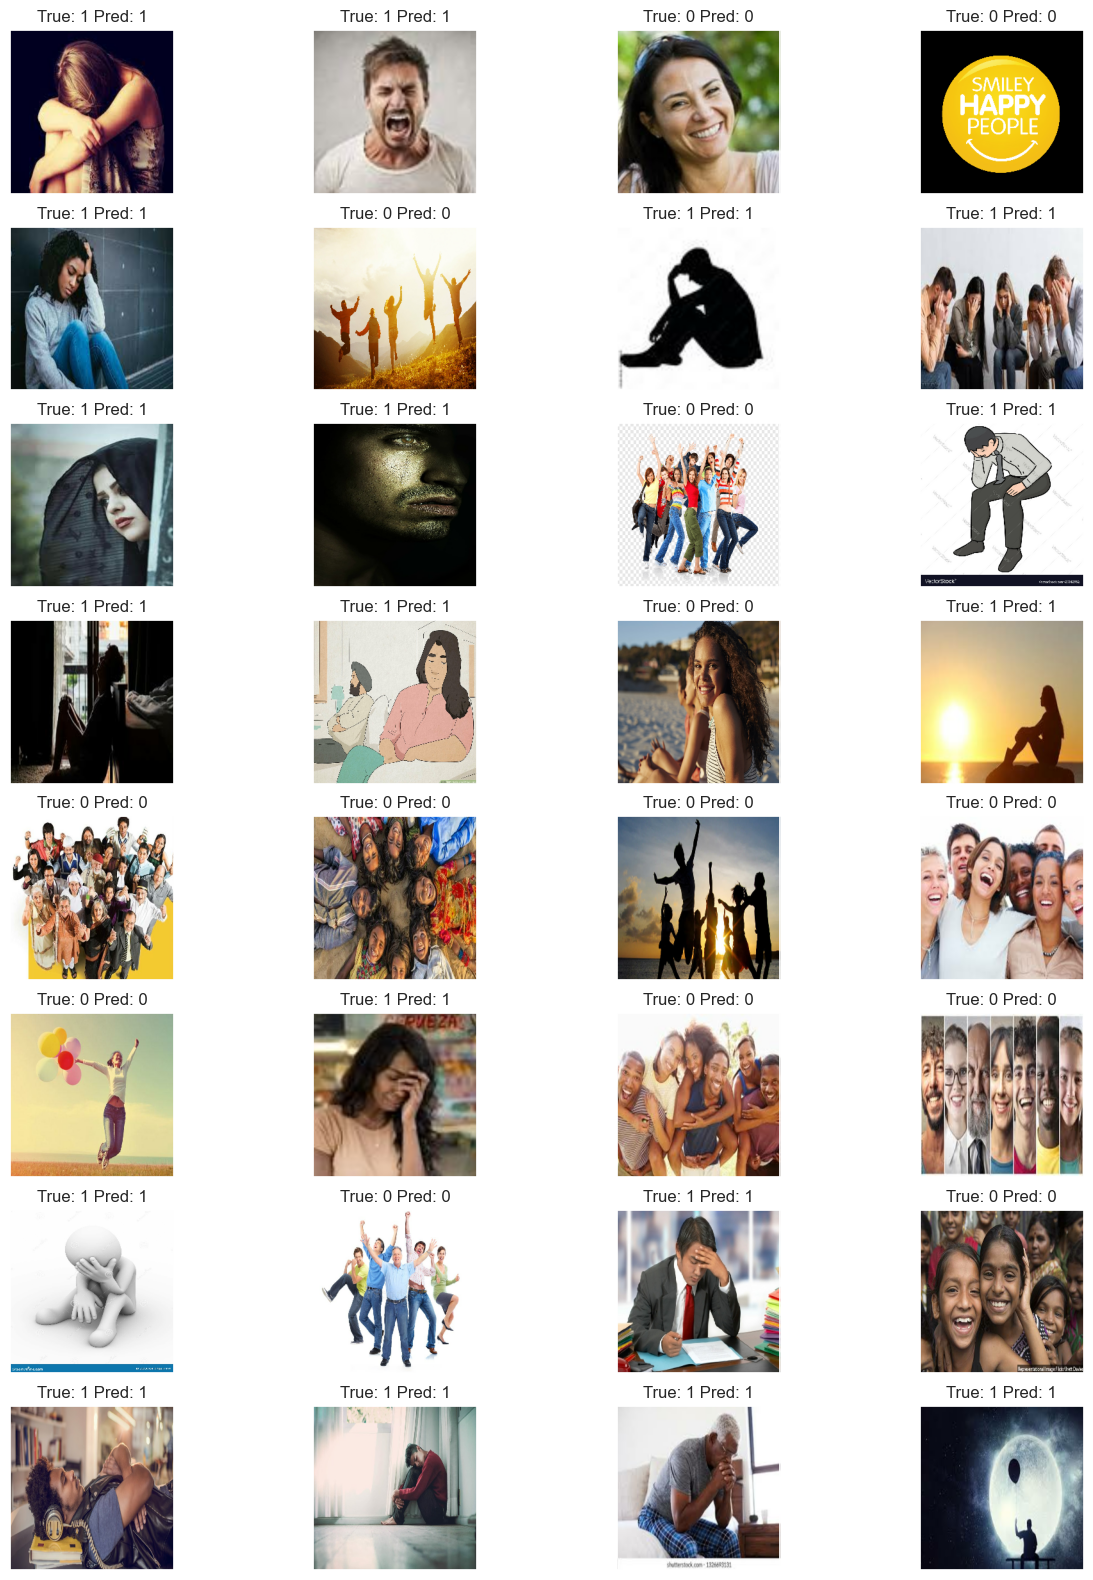

In [129]:

fig = plt.figure(figsize=(15, 20), dpi=100)
for p, i in enumerate(test_batch[0]):
    ax = fig.add_subplot(8, 4, p+1, xticks=[], yticks=[])
    ax.imshow(i)
    ax.set_title(f'True: {test_batch[1][p]} Pred: {preds[p]}')


## Conclusion

#### With the initial model being trained on 192 images with 32 used for validation data and ran on only 20 epochs, the model performed extremely well. The validation accuracy hit 1.0 after only 10 epochs. With the test images above, the model also classified them all correctly. I'm very happy with the results and a model like this could be used for emotion detection in images or video frames. Expanding to other facial expressions and emotions would make it even more useful.